# AI in the Public Sector

**Research Question:** Is there a statistically significant difference in the **Government AI Readiness Index** between Global North and Global South countries? If so, what is the strength of the correlation between this readiness index and the **Corruption Perceptions Index (CPI)** or the **World Happiness Report?**

In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Add the warnings filter to suppress minor Seaborn FutureWarning messages
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression # Import for the final model
import numpy as np # Import for the final model

### Data Loading and Merging

In [2]:
# 1. Create manual table: Government AI Readiness Index 2024
data_ai = {
    'Country': ['United States', 'Singapore', 'United Kingdom', 'Germany', 'Finland',
        'Australia', 'United Arab Emirates', 'Switzerland', 'Japan', 'Brazil',
        'Chile', 'Uruguay', 'Mexico', 'Colombia', 'Peru', 'Argentina',
        'Ecuador', 'Venezuela'],
    'AI_Readiness_Score': [87.03, 84.25, 78.88, 76.90, 76.48, 76.44, 75.66, 69.42, 68.42,
        65.89, 63.19, 62.21, 54.43, 51.05, 46.10, 45.48, 44.93, 25.13]
}

df_ai = pd.DataFrame(data_ai)

# 2. Load CSV files with correct encoding
try:
    # Use 'latin1' encoding to handle special characters
    df_happiness = pd.read_csv('WHR24_Data_Figure_2.1.csv', encoding='latin1')
    df_corruption = pd.read_csv('CPI2024-Results-and-trends.csv', encoding='latin1', header=2)
except FileNotFoundError as e:
    print(f"Error: File not found. Ensure the name and location are correct.\nDetails: {e}")
except UnicodeDecodeError as e:
    print("Decoding error. Try another encoding like 'iso-8859-1'.")
    print(f"Details: {e}")
else:
    # 3. Standardize country names for merging
    country_mapping = {
        'United States': 'United States of America',
        'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland'
        # Add more mappings if inconsistencies are found
    }
    df_ai['Country'] = df_ai['Country'].replace(country_mapping)
    df_happiness = df_happiness.rename(columns={'Country name': 'Country', 'Ladder score': 'Happiness_Score'})
    df_corruption = df_corruption.rename(columns={'Country': 'Country', 'CPI 2024 Score': 'Corruption_Score'}) # Check column names here

# 3. Rename CPI column for merging (corrected from original code)
df_corruption = df_corruption.rename(columns={'Country / Territory': 'Country'}) 

# 4. Merge the DataFrames
df_final = pd.merge(df_ai, df_happiness[['Country', 'Happiness_Score']], on='Country', how='left')
df_final = pd.merge(df_final, df_corruption[['Country', 'CPI 2024 score']], on='Country', how='left')

# 5. Classify countries into Global North and Global South based on UNCTAD criteria
global_north_countries = [
        'United States of America', 'Singapore', 'United Kingdom of Great Britain and Northern Ireland',
        'Germany', 'Finland', 'Australia', 'United Arab Emirates', 'Switzerland',
        'Japan', 'South Korea', 'Israel', 'Canada', 'Denmark', 'Sweden', 'Norway',
        'Iceland', 'New Zealand'
    ]
    
def classify_region(country):
    return 'Global North' if country in global_north_countries else 'Global South'
    
df_final['Global_Region'] = df_final['Country'].apply(classify_region)

df_final

,Country,AI_Readiness_Score,Happiness_Score,CPI 2024 score,Global_Region
0,United States of America,87.03,NaN,NaN,Global North
1,Singapore,84.25,6.523,84.0,Global North
2,United Kingdom of Great Britain and Northern I...,78.88,NaN,NaN,Global North
3,Germany,76.90,6.719,75.0,Global North
4,Finland,76.48,7.741,88.0,Global North
5,Australia,76.44,7.057,77.0,Global North
6,United Arab Emirates,75.66,6.733,68.0,Global North
7,Switzerland,69.42,7.060,81.0,Global North
8,Japan,68.42,6.060,71.0,Global North
9,Brazil,65.89,6.272,34.0,Global South


### Data Cleaning: Handling Missing Values and Renaming

In [3]:
## Data Cleaning: Handling Missing Values and Renaming

# 1. Fill NaN values for United Kingdom
df_final.loc[df_final['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'Happiness_Score'] = 6.749
df_final.loc[df_final['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'CPI 2024 score'] = 71

# 2. Fill NaN values for United States of America
df_final.loc[df_final['Country'] == 'United States of America', 'Happiness_Score'] = 6.725
df_final.loc[df_final['Country'] == 'United States of America', 'CPI 2024 score'] = 65

# 3. Shorten names for visualizations 
df_final.loc[df_final['Country'] == 'United Kingdom of Great Britain and Northern Ireland', 'Country'] = 'UK'
df_final.loc[df_final['Country'] == 'United Arab Emirates', 'Country'] = 'UAE'
df_final.loc[df_final['Country'] == 'United States of America', 'Country'] = 'USA'

# Display the updated DataFrame
print(df_final.head())

     Country  AI_Readiness_Score  Happiness_Score  CPI 2024 score  \
0        USA               87.03            6.725            65.0   
1  Singapore               84.25            6.523            84.0   
2         UK               78.88            6.749            71.0   
3    Germany               76.90            6.719            75.0   
4    Finland               76.48            7.741            88.0   

  Global_Region  
0  Global North  
1  Global North  
2  Global North  
3  Global North  
4  Global North  


## Data Visualization
### Bar Plot: AI Readiness by Global Region

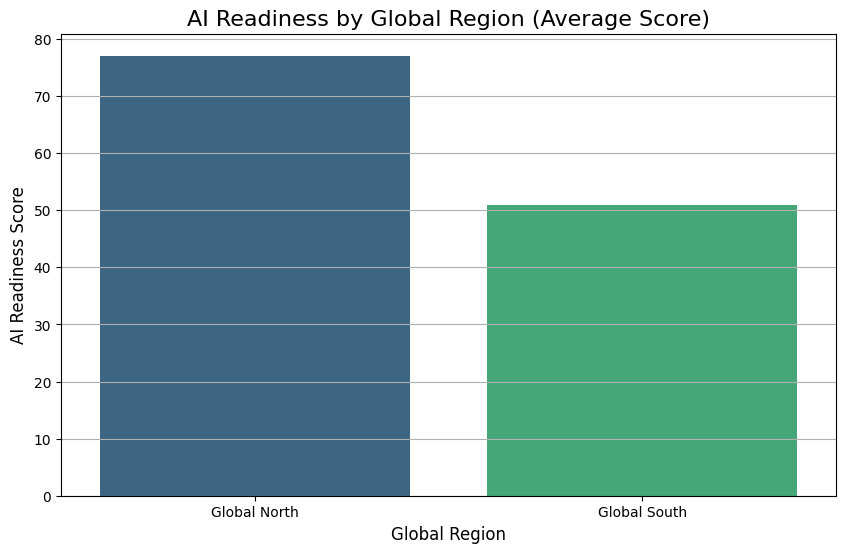

In [11]:
## Bar Plot: AI Readiness by Region

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Global_Region',
    y='AI_Readiness_Score',
    data=df_final,
    errorbar=None,
    hue='Global_Region', # Using hue correctly for color coding
    palette='viridis',
    legend=False # Suppress legend if it's redundant
)

plt.title('AI Readiness by Global Region (Average Score)', fontsize=16)
plt.xlabel('Global Region', fontsize=12)
plt.ylabel('AI Readiness Score', fontsize=12)
plt.grid(axis='y')

plt.show()

### Scatter Plot: Happiness vs. Corruption

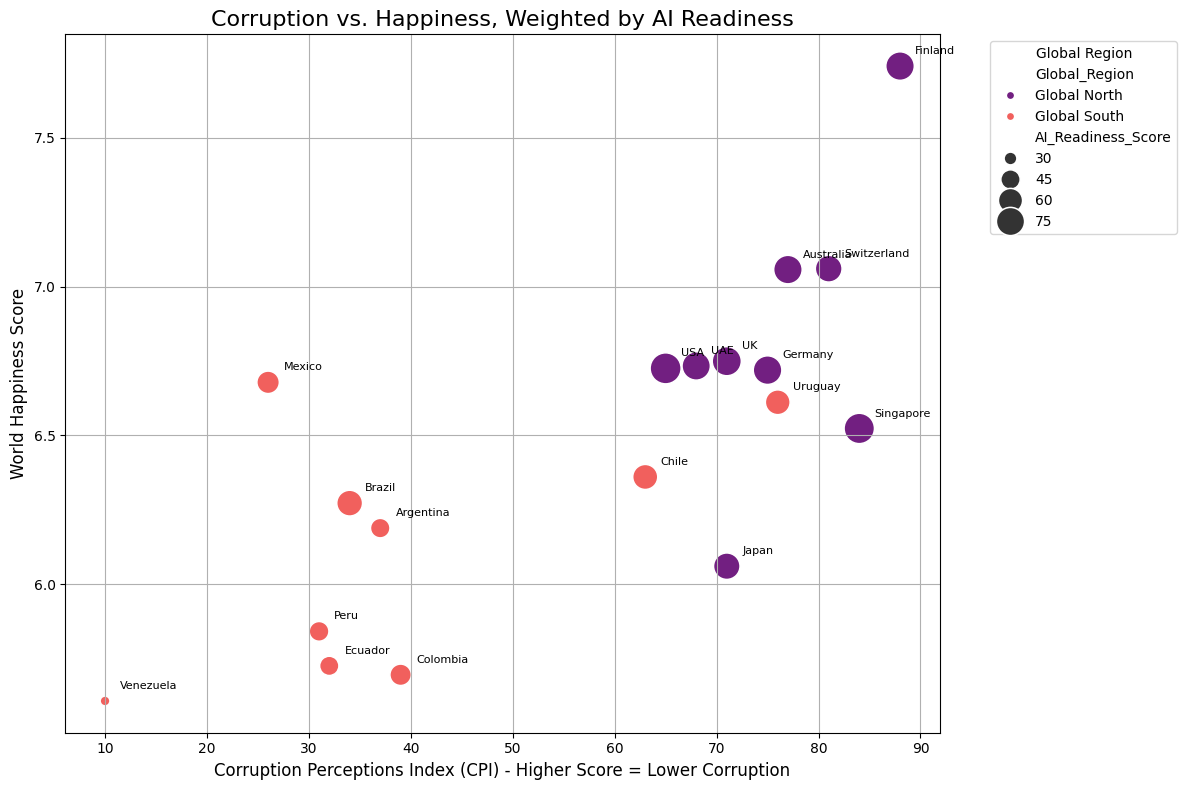

In [12]:
## Scatter Plot: Happiness vs. Corruption

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='CPI 2024 score',
    y='Happiness_Score',
    data=df_final,
    hue='Global_Region',
    size='AI_Readiness_Score',
    sizes=(50, 500),
    palette='magma'
)

for i, row in df_final.iterrows():
    plt.text(
        row['CPI 2024 score'] + 1.5,
        row['Happiness_Score'] + 0.05,
        row['Country'],
        ha='left',
        va='center',
        fontsize=8
    )

plt.title('Corruption vs. Happiness, Weighted by AI Readiness', fontsize=16)
plt.xlabel('Corruption Perceptions Index (CPI) - Higher Score = Lower Corruption', fontsize=12)
plt.ylabel('World Happiness Score', fontsize=12)
plt.legend(title='Global Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis of Data Visualizations

### North vs. South Global Divide

The bar plot reveals a **clear difference** in the average AI Readiness Score between the Global North and Global South. While the average might mitigate some extreme values, the **scatter plot** more effectively illustrates the **real gulf**: Global North countries consistently cluster in the upper-right quadrant (High AI Readiness, High CPI/Low Corruption), showing a much clearer separation.

### The Happiness-Corruption Relationship

The overall trend—that **lower perceived corruption (higher CPI scores) correlates with higher happiness**—is an expected global pattern. However, outlier cases like **Mexico** and **Japan** demonstrate that this relationship is not a strict rule; other major factors (cultural resilience, social trust, economic stability) heavily influence citizen happiness in unexpected ways.

### Technical Clarity: The CPI Index

It is **crucial to emphasize** that a **higher score** on the Corruption Perceptions Index (CPI) signifies a **lower perception of corruption** and greater transparency. This technical detail prevents misinterpretation when presenting the scatter plot.

## Correlation and Hypothesis Testing

In [6]:
## Correlation and Hypothesis Testing

# 1. Correlation between AI, Corruption, and Happiness: Pearson's r coefficient measures the linear relationship (from -1 to 1).
# 2. Student's T-Test for AI Readiness: The T-test will determine if the mean difference in AI readiness scores between the Global North and Global South is statistically significant (p-value < 0.05).

# Calculate correlations
corr_ia_corrupcion = df_final['AI_Readiness_Score'].corr(df_final['CPI 2024 score'])
corr_ia_felicidad = df_final['AI_Readiness_Score'].corr(df_final['Happiness_Score'])

print("--- Correlation Coefficients ---")
print(f"Correlation between AI Readiness and Corruption Perception (CPI): {corr_ia_corrupcion:.2f}")
print(f"Correlation between AI Readiness and Happiness: {corr_ia_felicidad:.2f}")

print("\n--- Student's T-Test ---")
# Separate data into two groups
df_norte = df_final[df_final['Global_Region'] == 'Global North']['AI_Readiness_Score']
df_sur = df_final[df_final['Global_Region'] == 'Global South']['AI_Readiness_Score']

# Perform the Student's T-Test (assuming unequal variances, which is safer)
t_statistic, p_value = stats.ttest_ind(df_norte, df_sur, equal_var=False)

print(f"T-Statistic: {t_statistic:.2f}")
print(f"P-Value: {p_value:.3f}")

--- Correlation Coefficients ---
Correlation between AI Readiness and Corruption Perception (CPI): 0.85
Correlation between AI Readiness and Happiness: 0.73

--- Student's T-Test ---
T-Statistic: 5.61
P-Value: 0.000


## Conclusion: Correlations and Hypothesis Test

### Strong and Positive Correlation

* **AI Readiness vs. Corruption (CPI):** The strong correlation coefficient of **0.85** is highly significant. This establishes a powerful positive relationship: **higher government AI readiness is strongly linked to lower perceived corruption (higher CPI scores).**
* **AI Readiness vs. Happiness:** The correlation of **0.73** indicates a positive but more moderate relationship.

This confirms the hypothesis: **trust and government transparency**, as reflected by the CPI, are **more directly tied** to public sector AI adoption than is the general happiness of the citizenry.

### Statistically Significant Difference (T-Test)

The P-value of **0.000** from the T-test is the most important finding. A P-value this low is far below the standard 0.05 threshold.

**Conclusion:** We can confidently conclude that the difference in AI readiness between Global North and Global South countries is **not random.** It is a **real and statistically significant gap.**

Ultimately, this analysis demonstrates that the AI readiness gap is a real phenomenon. Furthermore, AI maturity is strongly linked to perceived government transparency. A country with a solid, transparent governance foundation appears better positioned to adopt and implement AI effectively in the public sector.

## Analysis of Outlier Cases

Comparison Table:
   Country  AI_Readiness_Score  Happiness_Score  CPI 2024 score Global_Region
0      USA               87.03            6.725            65.0  Global North
2       UK               78.88            6.749            71.0  Global North
8    Japan               68.42            6.060            71.0  Global North
9   Brazil               65.89            6.272            34.0  Global South
12  Mexico               54.43            6.678            26.0  Global South


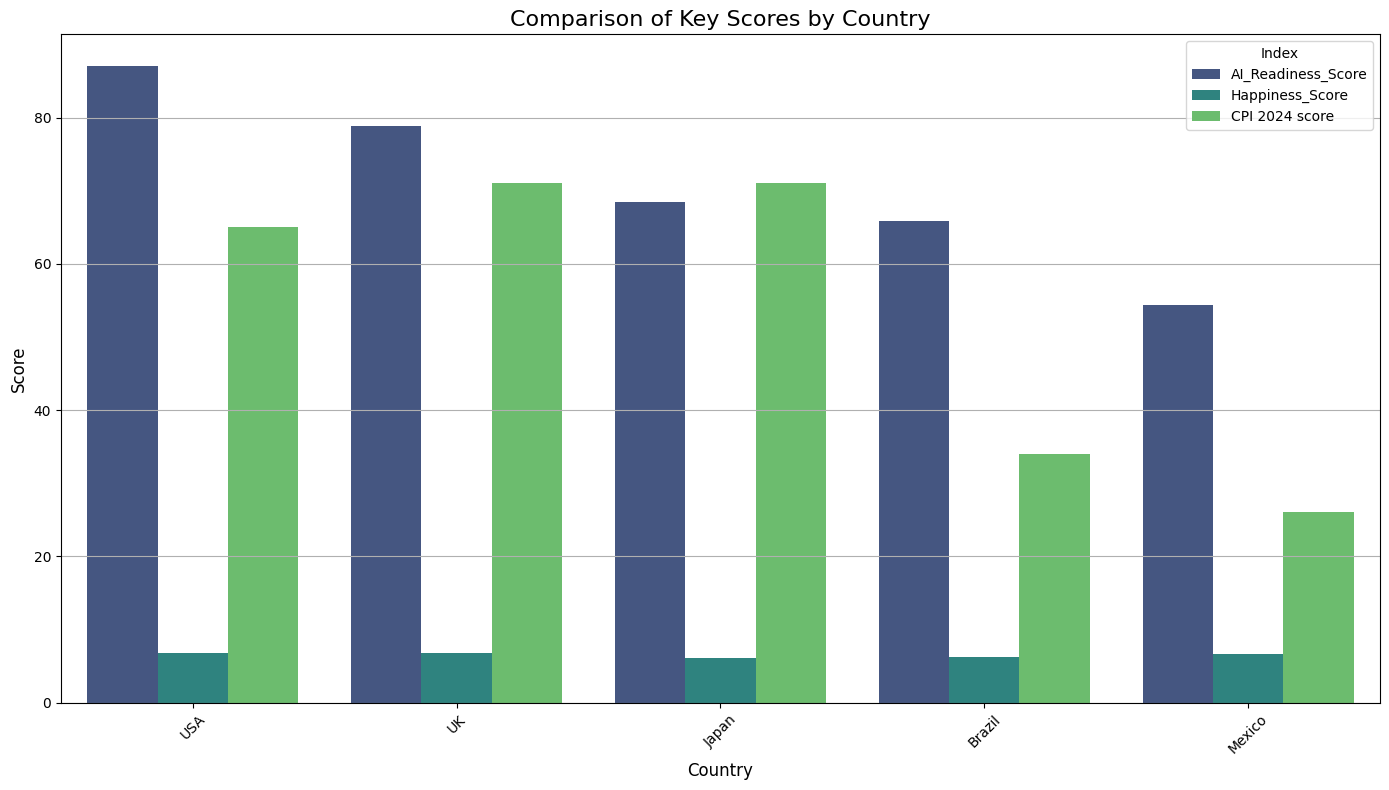

In [13]:
## Analysis of Outlier Cases

# Filter data for countries of interest
paises_interes = ['Mexico', 'Japan', 'Brazil', 'UK', 'USA']
df_comparacion = df_final[df_final['Country'].isin(paises_interes)].copy()

# Display the comparison table
print("Comparison Table:")
print(df_comparacion)

# Restructure the DataFrame for visualization
df_comparacion_melted = df_comparacion.melt(id_vars=['Country'],
                                            value_vars=['AI_Readiness_Score', 'Happiness_Score', 'CPI 2024 score'],
                                            var_name='Variable',
                                            value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(
    x='Country',
    y='Score',
    hue='Variable',
    data=df_comparacion_melted,
    palette='viridis'
)

plt.title('Comparison of Key Scores by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend(title='Index', loc='upper right')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Conclusion: Outlier Cases

### Mexico: The Global South Challenge

The bar chart clearly shows that **Mexico** lags in all three main indicators. This illustrates the significant hurdle many Global South countries face in investing in technologies like AI, even those with large, active populations.

### Japan vs. Brazil: The Strategic Factor

This is a highly valuable insight. The fact that **Japan and Brazil** have **similar AI Readiness Scores** despite vast differences in their Corruption Perception Index (CPI) is strong evidence that **technological development is not always directly tied to governance levels.** This reinforces the idea that other factors, such as strategic investment or existing infrastructure, can be powerful determinants.

### The USA and Happiness

**The United States (USA)** excels in AI readiness, consistent with its technological leadership. However, the observation about happiness scores is key: despite large differences in technology and governance, the **Happiness Scores are surprisingly similar** across all these countries. This suggests that happiness is a complex metric influenced by factors far beyond government technology and transparency.

## AI Readiness Prediction Model

In [8]:
## AI Readiness Prediction Model

# Install scikit-learn (only needed once if not installed)
# %pip install scikit-learn

# Import is already at the top, but here for context:
# import numpy as np
# from sklearn.linear_model import LinearRegression

# Define variables
X = df_final[['CPI 2024 score']]  # Predictor variable (Corruption Index)
y = df_final['AI_Readiness_Score']  # Target variable (AI Readiness)

# Create and train the linear regression model
modelo = LinearRegression()
modelo.fit(X, y)

# Get coefficients
pendiente = modelo.coef_[0]
punto_corte = modelo.intercept_

print(f"The regression line equation is: y = {pendiente:.2f}x + {punto_corte:.2f}")
print(f"Slope (m): {pendiente:.2f}")
print(f"Y-Intercept (b): {punto_corte:.2f}")

The regression line equation is: y = 0.59x + 30.31
Slope (m): 0.59
Y-Intercept (b): 30.31


### Using the Predictive Model

The linear regression model allows us to estimate a country's AI readiness score based solely on its corruption score.

**Example Prediction:** To predict the AI readiness of a country with a CPI score of **45**:

$AI\_Readiness\_Predicted = 0.59 \times 45 + 30.31$

The result would be approximately **56.86**. This demonstrates the predictive power of the model, allowing for reasonable estimates based on a single key governance metric.

# FINAL PROJECT CONCLUSION

Throughout this analysis, we have moved from an initial observation about governance to a deep, global study of the technological readiness gap. The most critical findings of this data analysis journey are:

### 1. The Global Technology and Governance Divide

A clear and **statistically significant gap** exists in public sector AI maturity between the Global North and Global South ($P < 0.05$). This demonstrates that the difference is a robust, non-random global phenomenon.

### 2. Governance as the Pillar of Innovation

The relationship between governance and technology is profound. We found a **strong positive correlation** ($r=0.85$) between AI readiness and the perception of low corruption. This suggests that countries with more transparent, established governance are inherently better positioned to adopt and implement complex technologies like AI effectively.

### 3. The Strategic Factor and Outliers

While corruption is a powerful predictor (regression slope: 0.59), outlier cases like **Japan and Brazil** remind us that technology adoption is not the sole factor. Their similar AI scores, despite large differences in CPI, indicate that **strategic investment in R&D and existing technical infrastructure** can partially override governance deficits.

### 4. The Complexity of Citizen Happiness

An unexpected finding was that, despite the vast technological and governance gaps, **happiness levels** between the Global North and South countries are much more similar than anticipated. This suggests that citizen happiness is a complex metric influenced by factors far beyond the scope of government AI and corruption indices.

**In summary:** Successful technological development in the public sector is not merely a function of wealth; it is a **direct reflection of transparent governance and strategic national investment.** The effective implementation of AI is, therefore, a barometer of a well-organized and innovation-valuing public ecosystem.

### Data Export

In [14]:
# Data Export
df_final.to_csv('AI_Public_Sector.csv', index=False)

print("File exported successfully!")
print("Look for 'Proyecto_IA_Global.csv' in your working folder.")

File exported successfully!
Look for 'Proyecto_IA_Global.csv' in your working folder.
